In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Machine Learning / Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping



# Ignore warnings
warnings.filterwarnings('ignore')


In [ ]:
!pip install kagglehub
!pip install pmdarima

import kagglehub
path = kagglehub.dataset_download("saikumartamminana/crude-oil-price-prediction")
print("Dataset downloaded to:", path)



Dataset downloaded to: /kaggle/input/crude-oil-price-prediction


In [ ]:

!ls {path}


'Crude oil.csv'


In [ ]:

df = pd.read_csv(f"{path}/Crude oil.csv")
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/28/2022,87.90,241417.0,88.67,88.76,87.08
1,10/27/2022,88.26,273717.0,88.26,89.79,87.33
2,10/26/2022,87.91,271474.0,85.07,88.41,84.14
3,10/25/2022,85.32,226337.0,84.88,86.03,83.06
4,10/24/2022,84.58,238458.0,85.24,85.92,82.63


In [ ]:
df.shape

(2548, 6)

In [ ]:
df.isnull().sum()

,0
Date,0
Close/Last,0
Volume,31
Open,0
High,0
Low,0


In [ ]:
df.isna().sum()

,0
Date,0
Close/Last,0
Volume,31
Open,0
High,0
Low,0


In [ ]:
df['Volume'].describe()

,Volume
count,2.517000e+03
mean,3.954717e+05
std,2.345385e+05
min,1.530000e+02
25%,2.244770e+05
50%,3.638160e+05
75%,5.581500e+05
max,1.693652e+06


Missing values in the Volume column were filled using the median.
This method was chosen because the data is right-skewed, with significant outliers that would distort the mean.
The median provides a more robust and representative value for typical observations.

In [ ]:

df['Volume'].fillna(df['Volume'].median(), inplace=True)


In [ ]:
df.isnull().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


In [ ]:
df.duplicated().sum()


np.int64(0)

In [ ]:
df.columns

Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')

# Boxplot for 'Volume'
sns.boxplot(data=df, y='Volume')  # Reference column by name
plt.title('Boxplot for Volume')
plt.show()



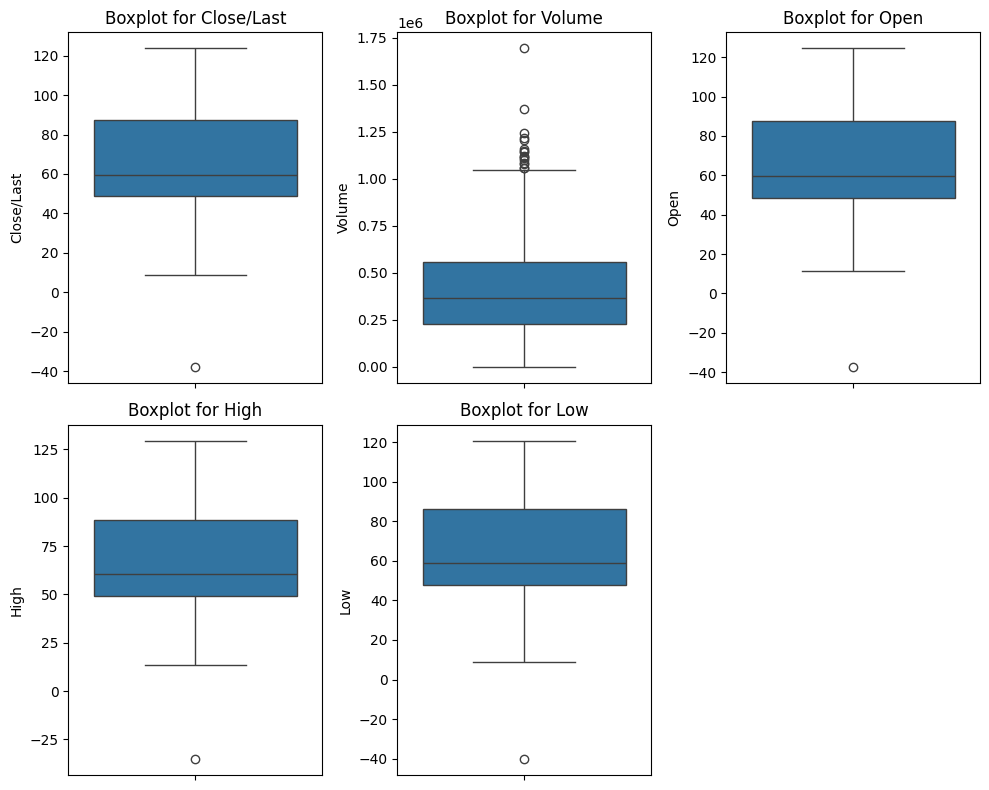

In [ ]:

# Set the figure size
plt.figure(figsize=(10, 8))


plt.subplot(2, 3, 1)
sns.boxplot(y=df['Close/Last'])
plt.title('Boxplot for Close/Last')


plt.subplot(2, 3, 2)
sns.boxplot(y=df['Volume'])
plt.title('Boxplot for Volume')


plt.subplot(2, 3, 3)
sns.boxplot(y=df['Open'])
plt.title('Boxplot for Open')

plt.subplot(2, 3, 4)
sns.boxplot(y=df['High'])
plt.title('Boxplot for High')

plt.subplot(2, 3, 5)
sns.boxplot(y=df['Low'])
plt.title('Boxplot for Low')


plt.tight_layout()

plt.show()


In [ ]:
lower_cap = df['Volume'].quantile(0.05)
upper_cap = df['Volume'].quantile(0.95)
print(f"Lower cap (5th percentile): {lower_cap}")
print(f"Upper cap (95th percentile): {upper_cap}")
df['Volume'] = np.where(df['Volume'] > upper_cap, upper_cap,
                        np.where(df['Volume'] < lower_cap, lower_cap, df['Volume']))


Lower cap (5th percentile): 25724.0
Upper cap (95th percentile): 791169.15


In [ ]:
df.columns

Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')

Text(0.5, 1.0, 'Boxplot for Volume')

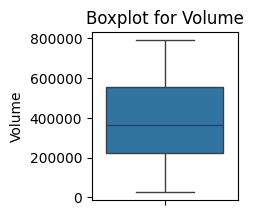

In [ ]:
plt.subplot(2, 3, 2)
sns.boxplot(df['Volume'])
plt.title('Boxplot for Volume')

In [ ]:
df.columns

Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

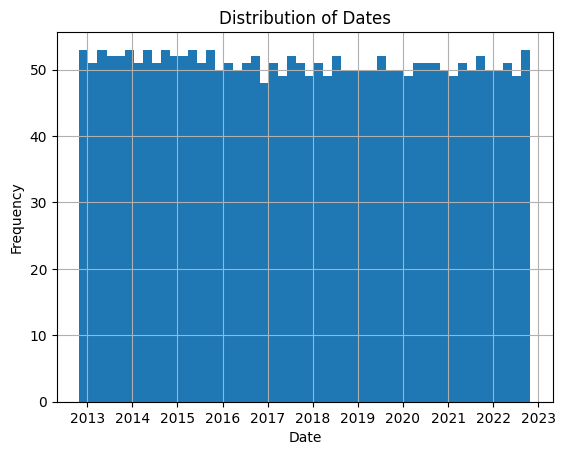

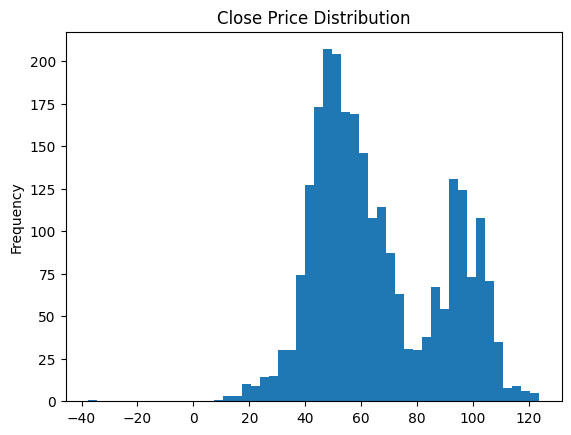

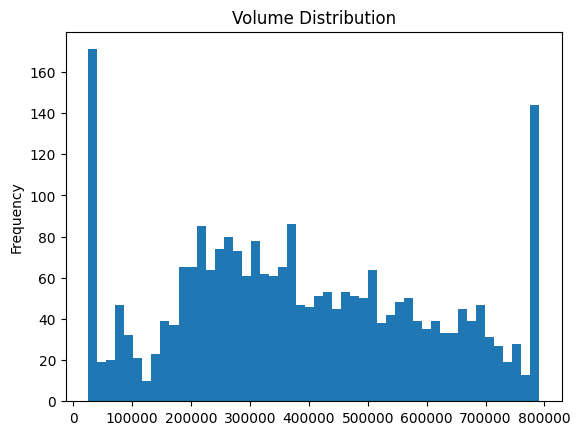

In [ ]:
df['Date'].hist(bins=50)
plt.title('Distribution of Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()
df['Close/Last'].plot(kind='hist', bins=50, title='Close Price Distribution')
plt.show()

df['Volume'].plot(kind='hist', bins=50, title='Volume Distribution')
plt.show()


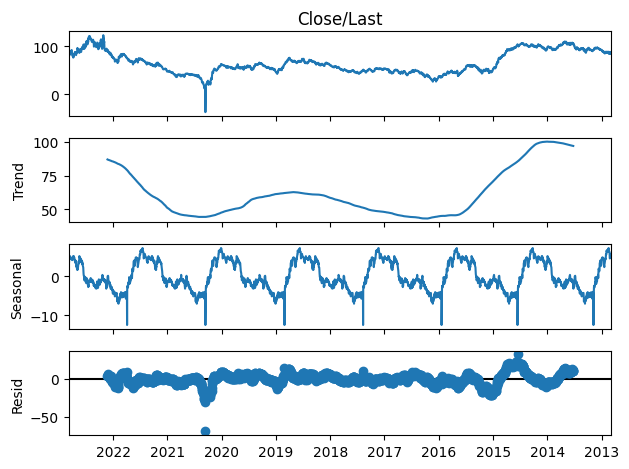

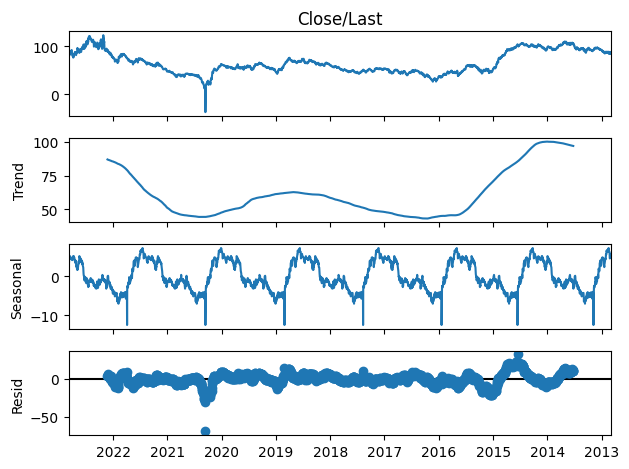

In [ ]:
result = seasonal_decompose(df.set_index('Date')['Close/Last'], model='additive', period=365)
result.plot()


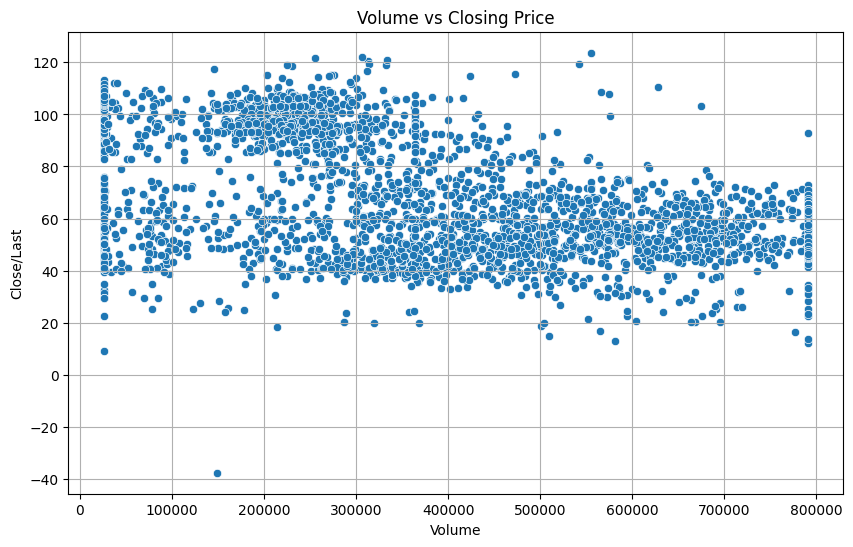

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Volume', y='Close/Last', data=df)
plt.title('Volume vs Closing Price')
plt.grid()
plt.show()

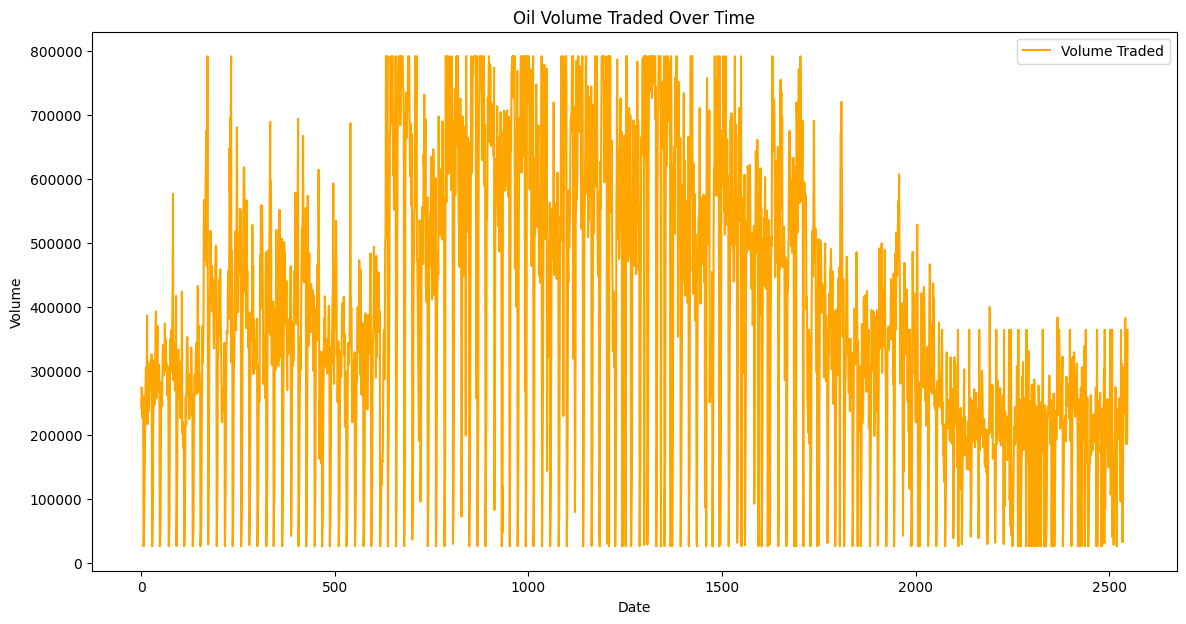

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Volume'], label='Volume Traded', color='orange')
plt.title('Oil Volume Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

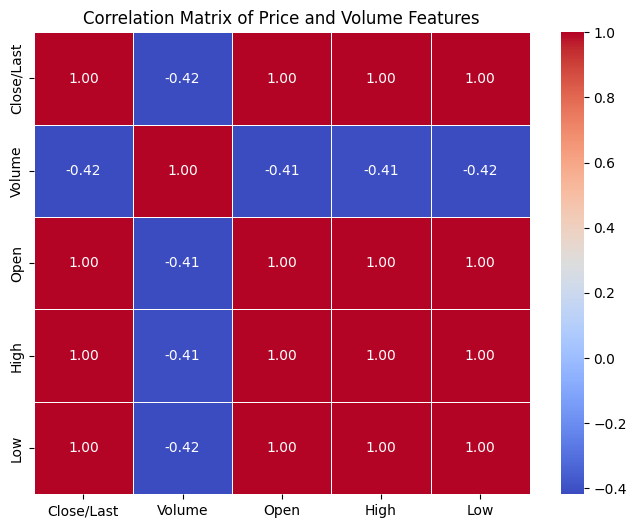

In [ ]:
corr_matrix = df[['Close/Last', 'Volume', 'Open', 'High', 'Low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Price and Volume Features')
plt.show()




In [ ]:
df['Price_Range_1'] = df['High'] - df['Low']
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
df.drop(columns=['Open', 'High', 'Low'], inplace=True)
print("Remaining Features after dropping correlated columns:", df.columns)


Remaining Features after dropping correlated columns: Index(['Date', 'Close/Last', 'Volume', 'Price_Range_1'], dtype='object')


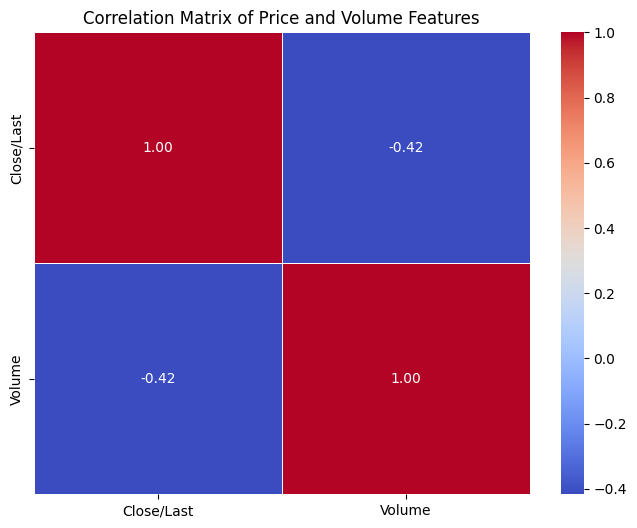

In [ ]:
corr_matrix = df[['Close/Last', 'Volume']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Price and Volume Features')
plt.show()


In [ ]:
close_diff_clean = df['Close/Last'].diff().dropna()
adf_diff = adfuller(close_diff_clean)
print(f'ADF Statistic (Differenced): {adf_diff[0]}')
print(f'p-value (Differenced): {adf_diff[1]}')

ADF Statistic (Differenced): -34.219377068944496
p-value (Differenced): 0.0


ADF Statistic: -1.6311397654314364
p-value: 0.46689417081931894
The time series is not stationary. Differencing is required.


<Axes: title={'center': 'Differenced Close Price (Filled Missing)'}>

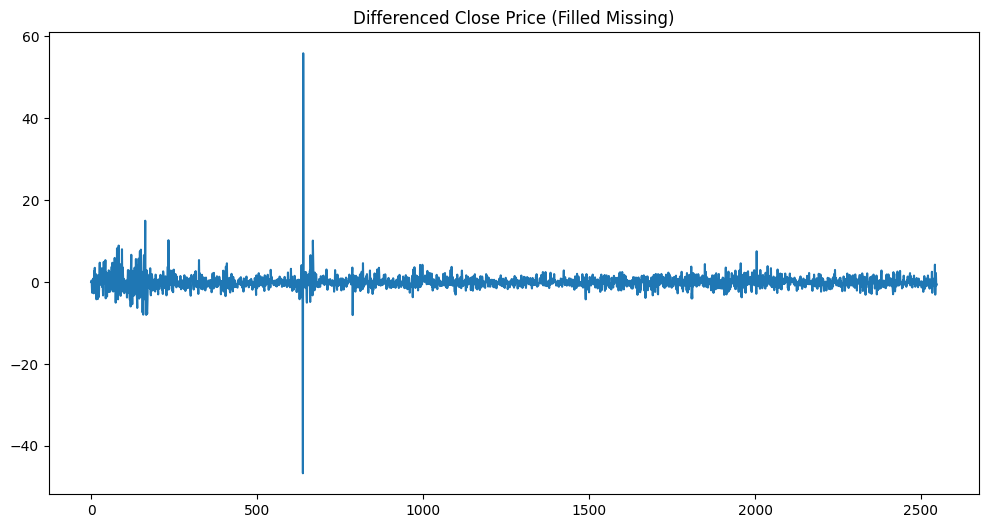

In [ ]:
adf_result = adfuller(df['Close/Last'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing is required.")
df['Close_diff'] = df['Close/Last'].diff()
df['Close_diff'] = df['Close_diff'].fillna(method='pad')
df['Close_diff'] = df['Close_diff'].fillna(0)
df['Close_diff'].plot(figsize=(12, 6), title='Differenced Close Price (Filled Missing)')



In [ ]:
df.columns

Index(['Date', 'Close/Last', 'Volume', 'Price_Range_1', 'Close_diff'], dtype='object')

In [ ]:
df.set_index('Date', inplace=True)

df['Day_of_week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

df['sin_day_of_week'] = np.sin(2 * np.pi * df['Day_of_week'] / 7)
df['cos_day_of_week'] = np.cos(2 * np.pi * df['Day_of_week'] / 7)
df['sin_month'] = np.sin(2 * np.pi * df['Month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Close_Lag_1'] = df['Close/Last'].shift(1)
df['Close_Lag_7'] = df['Close/Last'].shift(7)
df['Close_Lag_30'] = df['Close/Last'].shift(30)
df['Close_MA_7'] = df['Close/Last'].rolling(window=7).mean()
df['Close_MA_30'] = df['Close/Last'].rolling(window=30).mean()
df['Volume_MA_7'] = df['Volume'].rolling(window=7).mean()
df['Volume_MA_30'] = df['Volume'].rolling(window=30).mean()
df['Close_pct_change_1'] = df['Close/Last'].pct_change(1)
df['Volume_pct_change_1'] = df['Volume'].pct_change(1)

df = df.fillna(method='bfill')
df = df.fillna(method='ffill')



In [ ]:
print(df.columns)


Index(['Close/Last', 'Volume', 'Price_Range_1', 'Close_diff', 'Day_of_week',
       'Month', 'Quarter', 'sin_day_of_week', 'cos_day_of_week', 'sin_month',
       'cos_month', 'Close_Lag_1', 'Close_Lag_7', 'Close_Lag_30', 'Close_MA_7',
       'Close_MA_30', 'Volume_MA_7', 'Volume_MA_30', 'Close_pct_change_1',
       'Volume_pct_change_1'],
      dtype='object')


In [ ]:
df.head()
df.columns

Index(['Close/Last', 'Volume', 'Price_Range_1', 'Close_diff', 'Day_of_week',
       'Month', 'Quarter', 'sin_day_of_week', 'cos_day_of_week', 'sin_month',
       'cos_month', 'Close_Lag_1', 'Close_Lag_7', 'Close_Lag_30', 'Close_MA_7',
       'Close_MA_30', 'Volume_MA_7', 'Volume_MA_30', 'Close_pct_change_1',
       'Volume_pct_change_1'],
      dtype='object')

In [ ]:
df.isnull().sum()
df['Date_ordinal'] = df.index.map(lambda date: date.toordinal())


In [ ]:
df.head()

,Close/Last,Volume,Price_Range_1,Close_diff,Day_of_week,Month,Quarter,sin_day_of_week,cos_day_of_week,sin_month,...,Close_Lag_1,Close_Lag_7,Close_Lag_30,Close_MA_7,Close_MA_30,Volume_MA_7,Volume_MA_30,Close_pct_change_1,Volume_pct_change_1,Date_ordinal
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-28,87.90,241417.0,1.68,0.00,4,10,4,-0.433884,-0.900969,-0.866025,...,87.90,87.9,87.9,86.441429,85.127333,219580.714286,231880.233333,0.004096,0.133793,738456
2022-10-27,88.26,273717.0,2.46,0.36,3,10,4,0.433884,-0.900969,-0.866025,...,87.90,87.9,87.9,86.441429,85.127333,219580.714286,231880.233333,0.004096,0.133793,738455
2022-10-26,87.91,271474.0,4.27,-0.35,2,10,4,0.974928,-0.222521,-0.866025,...,88.26,87.9,87.9,86.441429,85.127333,219580.714286,231880.233333,-0.003966,-0.008195,738454
2022-10-25,85.32,226337.0,2.97,-2.59,1,10,4,0.781831,0.623490,-0.866025,...,87.91,87.9,87.9,86.441429,85.127333,219580.714286,231880.233333,-0.029462,-0.166266,738453
2022-10-24,84.58,238458.0,3.29,-0.74,0,10,4,0.000000,1.000000,-0.866025,...,85.32,87.9,87.9,86.441429,85.127333,219580.714286,231880.233333,-0.008673,0.053553,738452


In [ ]:
df.isnull().sum()

,0
Close/Last,0
Volume,0
Price_Range_1,0
Close_diff,0
Day_of_week,0
Month,0
Quarter,0
sin_day_of_week,0
cos_day_of_week,0
sin_month,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2548 entries, 2022-10-28 to 2012-10-30
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close/Last           2548 non-null   float64
 1   Volume               2548 non-null   float64
 2   Price_Range_1        2548 non-null   float64
 3   Close_diff           2548 non-null   float64
 4   Day_of_week          2548 non-null   int32  
 5   Month                2548 non-null   int32  
 6   Quarter              2548 non-null   int32  
 7   sin_day_of_week      2548 non-null   float64
 8   cos_day_of_week      2548 non-null   float64
 9   sin_month            2548 non-null   float64
 10  cos_month            2548 non-null   float64
 11  Close_Lag_1          2548 non-null   float64
 12  Close_Lag_7          2548 non-null   float64
 13  Close_Lag_30         2548 non-null   float64
 14  Close_MA_7           2548 non-null   float64
 15  Close_MA_30         

ARIMA MSE: 1.25173
Hybrid MSE: 1.43808


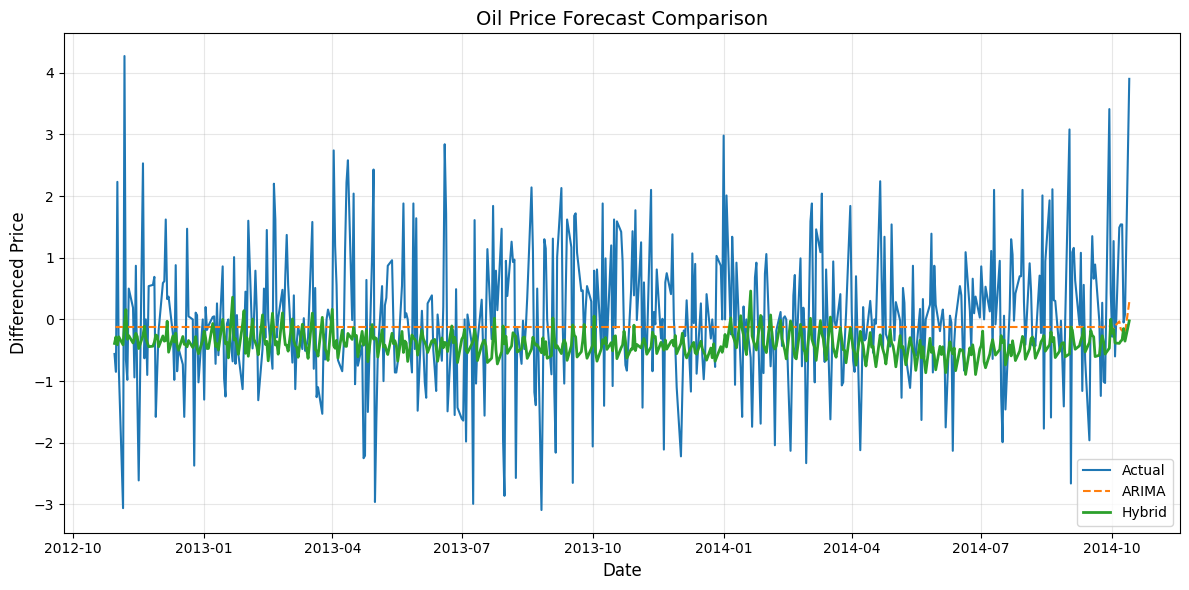

In [ ]:
# =============================================
# Import Libraries
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =============================================
# Configuration
# =============================================
TRAIN_SIZE = 0.8
FEATURES = [
    'Volume', 'Price_Range_1', 'Day_of_week', 'Month', 'Quarter',
    'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month',
    'Close_Lag_1', 'Close_Lag_7', 'Close_Lag_30', 'Close_MA_7',
    'Close_MA_30', 'Volume_MA_7', 'Volume_MA_30', 'Close_pct_change_1',
    'Volume_pct_change_1', 'Date_ordinal'
]

# =============================================
# Data Preparation
# =============================================
# Check required features
missing_features = [f for f in FEATURES + ['Close_diff'] if f not in df.columns]
if missing_features:
    raise ValueError(f"Missing columns in dataframe: {missing_features}")

# Train-test split
train_len = int(len(df) * TRAIN_SIZE)
train = df.iloc[:train_len].copy()
test = df.iloc[train_len:].copy()

# =============================================
# ARIMA Modeling
# =============================================
# Fit ARIMA model
arima = ARIMA(train['Close_diff'], order=(5,1,0))
arima_results = arima.fit()

# Generate in-sample residuals
train_residuals = pd.Series(
    arima_results.resid,
    index=train.index[1:]  # Skip first obs due to differencing
).dropna()

# ARIMA forecast for test set
arima_forecast = arima_results.get_forecast(steps=len(test))
arima_pred = arima_forecast.predicted_mean

# =============================================
# LSTM Preparation
# =============================================
# Prepare training data with residual lags
X_train = train[FEATURES].iloc[1:-1].copy()  # Align with residuals
X_train['Residual_Lag_1'] = train_residuals.shift(1).fillna(0)

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshape for LSTM [samples, timesteps, features]
n_steps = 1
X_train_reshaped = X_train_scaled.reshape(
    (X_train_scaled.shape[0], n_steps, X_train_scaled.shape[1])
)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, X_train_scaled.shape[1])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train LSTM on residuals
model.fit(
    X_train_reshaped,
    train_residuals.iloc[1:],  # Align with lagged features
    epochs=50,
    verbose=0
)

# =============================================
# Hybrid Forecasting
# =============================================
test_residuals = []
current_residual = train_residuals.iloc[-1]

for i in range(len(test)):
    # Prepare test features
    test_features = test[FEATURES].iloc[i].values.reshape(1, -1)
    test_features = np.append(test_features, current_residual).reshape(1, -1)

    # Scale and predict
    test_scaled = scaler.transform(test_features)
    test_reshaped = test_scaled.reshape(1, n_steps, -1)
    pred_residual = model.predict(test_reshaped, verbose=0)[0][0]

    test_residuals.append(pred_residual)
    current_residual = pred_residual

# Combine forecasts
hybrid_forecast = arima_pred.values + np.array(test_residuals)

# =============================================
# Evaluation & Visualization
# =============================================
# Calculate metrics
actual_values = test['Close_diff'].values
arima_mse = mean_squared_error(actual_values, arima_pred)
hybrid_mse = mean_squared_error(actual_values, hybrid_forecast)

print(f"ARIMA MSE: {arima_mse:.5f}")
print(f"Hybrid MSE: {hybrid_mse:.5f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, actual_values, label='Actual', color='#1f77b4')
plt.plot(test.index, arima_pred, label='ARIMA', color='#ff7f0e', linestyle='--')
plt.plot(test.index, hybrid_forecast, label='Hybrid', color='#2ca02c', linewidth=2)
plt.title('Oil Price Forecast Comparison', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Differenced Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2038
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3180.854
Date:                Mon, 28 Apr 2025   AIC                           6373.708
Time:                        17:39:01   BIC                           6407.423
Sample:                             0   HQIC                          6386.076
                               - 2038                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0568      0.003   -322.845      0.000      -1.063      -1.050
ar.L2         -0.9072      0.008   -108.884      0.000      -0.924      -0.891
ar.L3         -0.6954      0.014    -48.656      0.0

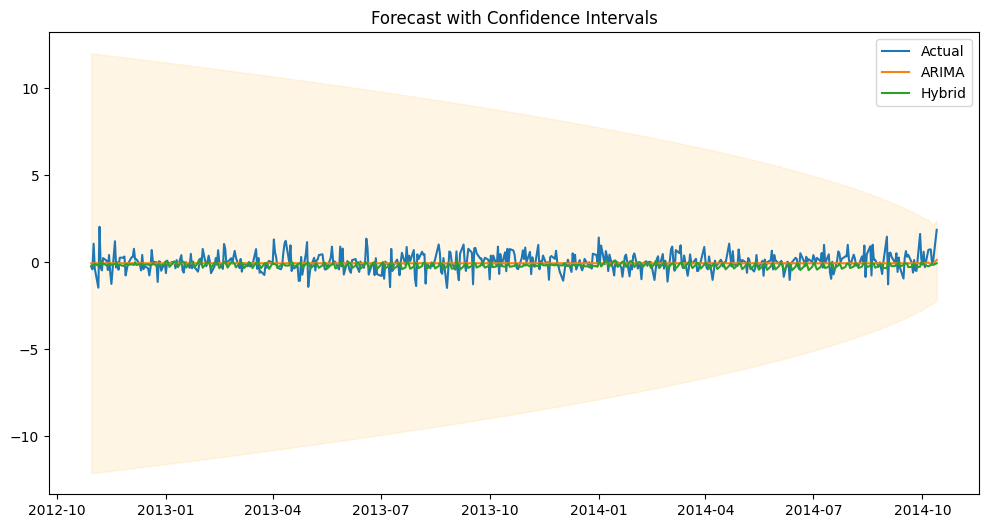

In [ ]:
plt.figure(figsize=(12, 6))
plt.fill_between(test.index,
                 arima_forecast.conf_int()['lower Close_diff'],
                 arima_forecast.conf_int()['upper Close_diff'],
                 color='orange', alpha=0.1)
plt.plot(test.index, test['Close_diff'], label='Actual')
plt.plot(test.index, arima_pred, label='ARIMA')
plt.plot(test.index, hybrid_forecast, label='Hybrid')
plt.title('Forecast with Confidence Intervals')
plt.legend()
plt.show()